In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


https://github.com/GinaWaldo/OASIS2-CNN

## 1. Basic Code

### 필요 라이브러리

In [ ]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
import skimage
import tensorflow as tf
import keras

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.utils import to_categorical
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import ELU
from tensorflow.keras.applications.vgg16 import VGG16
from skimage.transform import resize

### MrI 데이터 불러오기

In [ ]:
ROOT_DIR = "/content/drive/MyDrive/BrainWorks/data/oasis-2"

In [ ]:
# RAW 폴더 내의 파일 경로
raw_img_path = os.path.join(ROOT_DIR, 'OAS2_RAW_PART1', 'OAS2_RAW_PART1', 'OAS2_0099_MR2', 'RAW', 'mpr-3.nifti.img')
raw_hdr_path = os.path.join(ROOT_DIR, 'OAS2_RAW_PART1', 'OAS2_RAW_PART1', 'OAS2_0099_MR2', 'RAW', 'mpr-3.nifti.hdr')

In [ ]:
import nibabel as nib

# MRI 데이터 로드
img = nib.load(raw_img_path)

# 3D 데이터로 변환
img_data = img.get_fdata()

# 이미지 데이터의 기본 정보 확인
print(f"Image shape: {img_data.shape}")
print(f"Data type: {img_data.dtype}")

Image shape: (256, 256, 128, 1)
Data type: float64


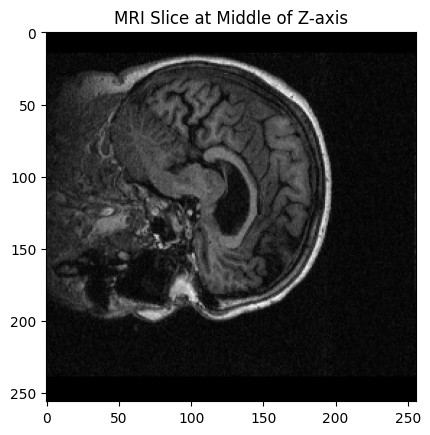

In [ ]:
# 3D 이미지의 중간 슬라이스 시각화 (Z축 중간에서 슬라이스)
plt.imshow(img_data[:, :, img_data.shape[2]//2], cmap='gray')
plt.title("MRI Slice at Middle of Z-axis")
plt.show()

### 메타데이터 처리

In [ ]:
# 메타데이터 경로 설정
metadata_path = os.path.join(ROOT_DIR, 'oasis_longitudinal_demographics-8d83e569fa2e2d30.xlsx')  # 실제 메타데이터 경로로 변경

# 메타데이터 불러오기
metadata = pd.read_excel(metadata_path)
metadata

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1986.550000,0.696106,0.883440
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004.479526,0.681062,0.875539
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678.290000,0.736336,1.045710
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1737.620000,0.713402,1.010000
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1697.911134,0.701236,1.033623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,OAS2_0185,OAS2_0185_MR2,Demented,2,842,M,R,82,16,1.0,28.0,0.5,1692.880000,0.693926,1.036690
369,OAS2_0185,OAS2_0185_MR3,Demented,3,2297,M,R,86,16,1.0,26.0,0.5,1688.009649,0.675457,1.039686
370,OAS2_0186,OAS2_0186_MR1,Nondemented,1,0,F,R,61,13,2.0,30.0,0.0,1319.020000,0.801006,1.330540
371,OAS2_0186,OAS2_0186_MR2,Nondemented,2,763,F,R,63,13,2.0,30.0,0.0,1326.650000,0.795981,1.322890


In [ ]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    float64
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(6), int64(4), object(5)
memory usage: 43.8+ KB


In [ ]:
metadata.describe()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.000000,373.000000,373.000000,373.000000,354.000000,371.000000,373.000000,373.000000,373.000000,373.000000
mean,1.882038,595.104558,77.013405,14.597855,2.460452,27.342318,0.290885,1488.121584,0.729556,1.195460
std,0.922843,635.485118,7.640957,2.876339,1.134005,3.683244,0.374557,176.135956,0.037141,0.138105
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1105.652499,0.644399,0.875539
25%,1.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1357.330000,0.700191,1.098979
50%,2.000000,552.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1470.041312,0.728789,1.193844
75%,2.000000,873.000000,82.000000,16.000000,3.000000,30.000000,0.500000,1596.936793,0.755669,1.292980
max,5.000000,2639.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.479526,0.836842,1.587298


Subject ID: 피험자의 고유 식별자입니다. 이 열은 동일한 피험자의 여러 MRI 스캔 데이터를 연결하는 데 사용됩니다.

MRI ID: 각 MRI 스캔의 고유 식별자입니다. 이는 특정 시간에 찍은 특정 MRI 스캔을 식별하는 데 사용됩니다.

Group: 피험자의 상태를 나타냅니다. 가능한 값으로는 'Nondemented' (비치매), 'Demented' (치매), 'Converted' (비치매에서 치매로 전환) 등이 있습니다.

Age: 피험자의 나이입니다. 이는 알츠하이머 병의 발병과 진행에 중요한 요인입니다.

MMSE (Mini-Mental State Examination): 인지 기능을 평가하는 점수입니다. 최대 30점이며, 낮은 점수는 인지 기능의 저하를 나타냅니다.

CDR (Clinical Dementia Rating): 임상 치매 등급으로, 치매의 심각도를 나타냅니다. 0은 비치매, 0.5는 경미한 치매, 1은 경증 치매, 2는 중등도 치매, 3은 중증 치매를 나타냅니다.

In [ ]:
# 필요한 열 선택
selected_columns = ['Subject ID', 'MRI ID', 'Group', 'Age', 'MMSE', 'CDR']
metadata_selected = metadata[selected_columns]

In [ ]:
# 각 열의 결측치 개수 확인
missing_values = metadata_selected.isnull().sum()
print("결측치 확인:", missing_values)

# 결측치가 있는 행 확인
print(metadata_selected[metadata_selected.isnull().any(axis=1)])

결측치 확인: Subject ID    0
MRI ID        0
Group         0
Age           0
MMSE          2
CDR           0
dtype: int64
    Subject ID         MRI ID     Group  Age  MMSE  CDR
357  OAS2_0181  OAS2_0181_MR2  Demented   75   NaN  1.0
358  OAS2_0181  OAS2_0181_MR3  Demented   77   NaN  1.0


MMSE (Mini-Mental State Examination) 점수는 인지 기능을 평가하는 중요한 지표이기 때문에, 단순히 중앙값으로 대체하는 것은 바람직하지 않을 수 있다. 특히, 결측치가 발생한 피험자가 치매(Demented)로 진단된 경우, 이러한 데이터를 그대로 사용하는 것이 모델에 악영향을 줄 수 있으므로
1. 다른 데이터와의 상관관계를 이용한 대체
2. 결측치 있는 행 제거


중에 방안 2를 선택함.

In [ ]:
# MMSE 결측치가 있는 행 제거
metadata_selected = metadata_selected.dropna(subset=['MMSE'])

# 결측치 제거 후 데이터 확인
print(metadata_selected.isnull().sum())

Subject ID    0
MRI ID        0
Group         0
Age           0
MMSE          0
CDR           0
dtype: int64


Group 컬럼
- Nondemented: 비치매 [0]
- Demented: 치매 [1]
- Converted: 비치매 상태에서 치매 상태로 전환된 피험자 [2]

"Converted"는 초기 스캔에서는 "Nondemented" (비치매)로 분류되었지만, 시간이 지나면서 후속 스캔에서 "Demented" (치매)로 진단된 경우를 나타냄

In [ ]:
# Group 컬럼의 숫자 버전 생성
metadata_selected['Group_num'] = metadata_selected['Group'].map({'Nondemented': 0, 'Demented': 1, 'Converted': 2})

# 변환 후 확인
print("Group 컬럼 라벨 인코딩 후:", metadata_selected['Group_num'].unique())

Group 컬럼 라벨 인코딩 후: [0 1 2]


In [ ]:
# 각 클래스(Group_num) 당 데이터 개수 확인
class_counts = metadata_selected['Group_num'].value_counts()

# 클래스 당 데이터 개수 출력
for class_num, count in class_counts.items():
    print(f"Class {class_num} (Label {class_num}) 데이터 개수: {count}개")

Class 0 (Label 0) 데이터 개수: 190개
Class 1 (Label 1) 데이터 개수: 144개
Class 2 (Label 2) 데이터 개수: 37개


### MRI 데이터 전처리

NIfTI 파일 탐색 및 이미지 데이터 수집

In [ ]:
import os
import nibabel as nib
import gc
import numpy as np
import skimage.color
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
total_files = 0
total_size = 0
folder_image_counts = []

# 배치 처리
batch_size = 50
imagestrain1 = []
labels = []

def get_image_files(mri_id):
    """해당 MRI ID에 대한 파일 경로를 검색"""
    raw_folder_part1 = os.path.join(ROOT_DIR, 'OAS2_RAW_PART1', 'OAS2_RAW_PART1', mri_id, 'RAW')
    raw_folder_part2 = os.path.join(ROOT_DIR, 'OAS2_RAW_PART2', 'OAS2_RAW_PART2', mri_id, 'RAW')

    if os.path.exists(raw_folder_part1):
        return [os.path.join(raw_folder_part1, f) for f in os.listdir(raw_folder_part1) if f.endswith('.img')]
    elif os.path.exists(raw_folder_part2):
        return [os.path.join(raw_folder_part2, f) for f in os.listdir(raw_folder_part2) if f.endswith('.img')]
    else:
        return []

In [ ]:
for i in range(0, len(metadata_selected), batch_size):
    mri_data_list = []
    batch = metadata_selected.iloc[i:i + batch_size]

    for index, row in batch.iterrows():
        mri_id = row['MRI ID']
        img_files = get_image_files(mri_id)

        if not img_files:
            print(f"파일을 찾을 수 없습니다: {mri_id}")
            continue

        # 폴더의 이미지 파일 개수 저장
        folder_image_counts.append((mri_id, len(img_files)))
        total_files += len(img_files)

        for img_file in img_files:
            try:
                img = nib.load(img_file)
                img_data = img.get_fdata()
                mri_data_list.append(img_data)

                # 데이터 크기 계산 (바이트 단위로)
                total_size += img_data.nbytes

                # 레이블 추가
                labels.append(row['Group_num'])

            except Exception as e:
                print(f"파일을 불러오는데 실패했습니다: {img_file}, 오류: {e}")

    # CNN 모델 학습을 위한 데이터 전처리
    for img_data in mri_data_list:
        img_resized = resize(img_data[:, :, img_data.shape[2]//2], (256, 256), anti_aliasing=True)
        imagestrain1.append(skimage.color.gray2rgb(img_resized))

    # 메모리 확보
    del mri_data_list
    gc.collect()

In [ ]:
# 결과 출력
print(f"총 폴더 수: {len(folder_image_counts)}")
print(f"총 이미지 파일 수: {total_files}")
print(f"총 데이터 용량: {total_size / (1024 ** 3):.2f} GB")  # GB로 변환

# 각 폴더에 대한 이미지 파일 수 출력
for mri_id, count in folder_image_counts:
    print(f"{mri_id} 폴더의 이미지 파일 수: {count}")

총 폴더 수: 371
총 이미지 파일 수: 1361
총 데이터 용량: 85.06 GB
OAS2_0001_MR1 폴더의 이미지 파일 수: 3
OAS2_0001_MR2 폴더의 이미지 파일 수: 3
OAS2_0002_MR1 폴더의 이미지 파일 수: 4
OAS2_0002_MR2 폴더의 이미지 파일 수: 4
OAS2_0002_MR3 폴더의 이미지 파일 수: 3
OAS2_0004_MR1 폴더의 이미지 파일 수: 4
OAS2_0004_MR2 폴더의 이미지 파일 수: 4
OAS2_0005_MR1 폴더의 이미지 파일 수: 4
OAS2_0005_MR2 폴더의 이미지 파일 수: 3
OAS2_0005_MR3 폴더의 이미지 파일 수: 3
OAS2_0007_MR1 폴더의 이미지 파일 수: 4
OAS2_0007_MR3 폴더의 이미지 파일 수: 4
OAS2_0007_MR4 폴더의 이미지 파일 수: 3
OAS2_0008_MR1 폴더의 이미지 파일 수: 4
OAS2_0008_MR2 폴더의 이미지 파일 수: 4
OAS2_0009_MR1 폴더의 이미지 파일 수: 4
OAS2_0009_MR2 폴더의 이미지 파일 수: 4
OAS2_0010_MR1 폴더의 이미지 파일 수: 4
OAS2_0010_MR2 폴더의 이미지 파일 수: 3
OAS2_0012_MR1 폴더의 이미지 파일 수: 4
OAS2_0012_MR2 폴더의 이미지 파일 수: 5
OAS2_0012_MR3 폴더의 이미지 파일 수: 3
OAS2_0013_MR1 폴더의 이미지 파일 수: 4
OAS2_0013_MR2 폴더의 이미지 파일 수: 4
OAS2_0013_MR3 폴더의 이미지 파일 수: 3
OAS2_0014_MR1 폴더의 이미지 파일 수: 4
OAS2_0014_MR2 폴더의 이미지 파일 수: 4
OAS2_0016_MR1 폴더의 이미지 파일 수: 4
OAS2_0016_MR2 폴더의 이미지 파일 수: 4
OAS2_0017_MR1 폴더의 이미지 파일 수: 3
OAS2_0017_MR3 폴더의 이미지 파일 수: 4
OAS2_0017_MR4 폴더의 이미지 

## 데이터 전처리 및 모델 준비

In [ ]:
# 전체 데이터 전처리 완료 후
X = np.array(imagestrain1, dtype=np.float32)

# 텐서 차원 맞추기 (형태를 (batch_size, height, width, channels)로 설정)
X = X.reshape((X.shape[0], 256, 256, 3))
X = tf.keras.applications.vgg16.preprocess_input(X, data_format=None)

y = np.array(labels)

In [ ]:
# 데이터셋을 학습 및 테스트로 분할
x_MRI_train, x_MRI_test, y_MRI_train, y_MRI_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 레이블을 원-핫 인코딩으로 변환
y_MRI_train_one_hot = to_categorical(y_MRI_train, num_classes=3)
y_MRI_test_one_hot = to_categorical(y_MRI_test, num_classes=3)

# 결과 출력
print(f"학습용 데이터 크기: {x_MRI_train.shape}")
print(f"테스트용 데이터 크기: {x_MRI_test.shape}")

학습용 데이터 크기: (1088, 256, 256, 3)
테스트용 데이터 크기: (273, 256, 256, 3)


### CNN 모델 구축 및 학습

In [ ]:
# CNN 모델 구성 및 학습
INIT_LR = 1e-3
epochs = 100
batch_size = 16

In [ ]:
from sklearn.metrics import classification_report, recall_score, precision_score
from tensorflow.keras.optimizers import Adagrad

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
for layer in conv_base.layers:
    layer.trainable = False

oasis_model = Sequential()
oasis_model.add(conv_base)
oasis_model.add(Flatten())
oasis_model.add(Dense(32, activation='linear'))
oasis_model.add(ELU(alpha=1))
oasis_model.add(Dropout(0.5))
oasis_model.add(Dense(3, activation='softmax'))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
oasis_model.compile(loss=tf.keras.losses.categorical_crossentropy,
                    optimizer=Adagrad(learning_rate=INIT_LR, decay=INIT_LR / 100),
                    metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
# # 데이터 형태와 값 확인
# print(f"x_MRI_train shape: {x_MRI_train.shape}")
# print(f"First sample of x_MRI_train: {x_MRI_train[0]}")
# print(f"y_MRI_train_one_hot shape: {y_MRI_train_one_hot.shape}")
# print(f"First sample of y_MRI_train_one_hot: {y_MRI_train_one_hot[0]}")

# # 각 레이어의 출력 크기 확인
# for layer in oasis_model.layers:
#     if hasattr(layer, 'output_shape'):
#         print(f"Layer {layer.name}: {layer.output_shape}")
#     else:
#         print(f"Layer {layer.name}: 출력 크기 미정 (해당 레이어는 output_shape 속성을 가지고 있지 않음)")

# # Flatten 레이어 이후 출력 형태 확인
# x_test_sample = x_MRI_train[:1]  # 임의로 한 샘플을 가져와서
# flatten_output = oasis_model.layers[1](x_test_sample)  # Flatten 레이어를 통과시킨 결과 확인
# print(f"Flatten 레이어의 출력 형태: {flatten_output.shape}")

# # 모델 요약 확인
# print(oasis_model.summary())



In [ ]:
# from tensorflow.keras.models import Model

# # 모델이 데이터를 올바르게 처리하는지 확인하기 위해 임의의 입력 데이터로 모델 빌드
# input_shape = (256, 256, 3)
# dummy_input = tf.keras.Input(shape=input_shape)
# dummy_output = oasis_model(dummy_input)

# # 모델을 다시 정의
# oasis_model = Model(inputs=dummy_input, outputs=dummy_output)

# # 모델 요약을 출력
# oasis_model.summary()


In [ ]:
print("First sample of x_MRI_train:", x_MRI_train[0])
print("First sample of y_MRI_train_one_hot:", y_MRI_train_one_hot[0])


First sample of x_MRI_train: [[[-103.939 -116.779 -123.68 ]
  [-103.939 -116.779 -123.68 ]
  [-103.939 -116.779 -123.68 ]
  ...
  [-103.939 -116.779 -123.68 ]
  [-103.939 -116.779 -123.68 ]
  [-103.939 -116.779 -123.68 ]]

 [[-103.939 -116.779 -123.68 ]
  [-103.939 -116.779 -123.68 ]
  [-103.939 -116.779 -123.68 ]
  ...
  [-103.939 -116.779 -123.68 ]
  [-103.939 -116.779 -123.68 ]
  [-103.939 -116.779 -123.68 ]]

 [[-103.939 -116.779 -123.68 ]
  [-103.939 -116.779 -123.68 ]
  [-103.939 -116.779 -123.68 ]
  ...
  [-103.939 -116.779 -123.68 ]
  [-103.939 -116.779 -123.68 ]
  [-103.939 -116.779 -123.68 ]]

 ...

 [[-103.939 -116.779 -123.68 ]
  [-103.939 -116.779 -123.68 ]
  [-103.939 -116.779 -123.68 ]
  ...
  [-103.939 -116.779 -123.68 ]
  [-103.939 -116.779 -123.68 ]
  [-103.939 -116.779 -123.68 ]]

 [[-103.939 -116.779 -123.68 ]
  [-103.939 -116.779 -123.68 ]
  [-103.939 -116.779 -123.68 ]
  ...
  [-103.939 -116.779 -123.68 ]
  [-103.939 -116.779 -123.68 ]
  [-103.939 -116.779 -123.68

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# 모델 학습
oasis_train = oasis_model.fit(
    x_MRI_train, y_MRI_train_one_hot,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,  # 학습 과정 출력
    validation_data=(x_MRI_test, y_MRI_test_one_hot),
    callbacks=[early_stopping]
)


Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 33s 207ms/step - AUC: 0.5892 - Precision: 0.4301 - Recall: 0.3912 - accuracy: 0.4234 - loss: 75.2082 - val_AUC: 0.7274 - val_Precision: 0.9000 - val_Recall: 0.0330 - val_accuracy: 0.5385 - val_loss: 0.9573
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - AUC: 0.5752 - Precision: 0.4147 - Recall: 0.3207 - accuracy: 0.3921 - loss: 1.3953 - val_AUC: 0.7215 - val_Precision: 1.0000 - val_Recall: 0.0183 - val_accuracy: 0.5275 - val_loss: 0.9568
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - AUC: 0.5734 - Precision: 0.3994 - Recall: 0.3335 - accuracy: 0.3967 - loss: 1.4061 - val_AUC: 0.7213 - val_Precision: 1.0000 - val_Recall: 0.0183 - val_accuracy: 0.5275 - val_loss: 0.9510
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - AUC: 0.5750 - Precision: 0.3939 - Recall: 0.3096 - accuracy: 0.3663 - loss: 1.3528 - val_AUC: 0.7353 - val_Precision: 1.0000 - val_Recall: 0.0366 - val_accuracy: 0.5458 - val_loss: 0.9269
Epoch 5/100
68/68 ━━━━━━━━

In [ ]:
from sklearn.metrics import classification_report, recall_score, precision_score

# CNN 모델 평가 함수 정의
def get_metrics(model, x_test, y_test):
    results = model.evaluate(x_test, y_test)
    accuracy = round(results[1] * 100, 2)
    y_pred = np.argmax(model.predict(x_test), axis=1)
    recall = round((recall_score(np.argmax(y_test, axis=1), y_pred, average="macro")) * 100, 2)
    precision = round(precision_score(np.argmax(y_test, axis=1), y_pred, average="macro") * 100, 2)
    return accuracy, recall, precision

model_accuracy, model_recall, model_precision = get_metrics(oasis_model, x_MRI_test, y_MRI_test_one_hot)

print(f"Model Accuracy: {model_accuracy}%")
print(f"Model Recall: {model_recall}%")
print(f"Model Precision: {model_precision}%")

9/9 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - AUC: 0.8604 - Precision: 0.7410 - Recall: 0.7356 - accuracy: 0.7384 - loss: 0.7026
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step
Model Accuracy: 72.53%
Model Recall: 51.49%
Model Precision: 51.85%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 데이터 증강 기법 적용
**Class 2 (Converted)**가 다른 두 클래스에 비해 상당히 적은 편. 데이터를 균형 잡힌 상태로 만들려면, **Class 2 (Converted)**의 데이터를 더 많이 확보하는 것이 좋음
-> 현재는 오류

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # ImageDataGenerator 설정
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# # "Converted" 카테고리의 이미지를 증강하여 추가
# converted_images = []
# converted_labels = []
# for img_data, label in zip(imagestrain1, labels):
#     if label == 2:  # "Converted" 카테고리일 경우
#         # 이미지가 (256, 256) 형태라면 (256, 256, 1)로 변환
#         if len(img_data.shape) == 2:
#             img_data = np.expand_dims(img_data, axis=-1)
#         # 만약 (256, 256, 1) 형태라면 (256, 256, 3)로 변환
#         if img_data.shape[-1] == 1:
#             img_data = np.repeat(img_data, 3, axis=-1)
#         img_data = np.expand_dims(img_data, axis=0)  # (1, height, width, channels) 형태로 변환
#         i = 0
#         for batch in datagen.flow(img_data, batch_size=1):
#             converted_images.append(batch[0])  # 배치의 첫 번째 이미지를 추가
#             converted_labels.append(label)
#             i += 1
#             if i >= 5:  # 각 이미지를 5배로 증강
#                 break

# # 원본 이미지 데이터와 증강된 데이터를 결합
# X_augmented = np.array(imagestrain1)
# converted_images = np.array(converted_images)

# X_augmented = np.concatenate((X_augmented, converted_images), axis=0)
# y_augmented = np.concatenate((labels, converted_labels), axis=0)

# # 텐서 차원 맞추기 (형태를 (batch_size, height, width, channels)로 설정)
# X_augmented = tf.keras.applications.vgg16.preprocess_input(X_augmented, data_format=None)

# # 데이터셋을 학습 및 테스트로 분할
# x_MRI_train, x_MRI_test, y_MRI_train, y_MRI_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=42)

# # 레이블을 원-핫 인코딩으로 변환
# y_MRI_train_one_hot = to_categorical(y_MRI_train, num_classes=3)
# y_MRI_test_one_hot = to_categorical(y_MRI_test, num_classes=3)

# # 결과 출력
# print(f"학습용 데이터 크기: {x_MRI_train.shape}")
# print(f"테스트용 데이터 크기: {x_MRI_test.shape}")


## t-SNE
 t-SNE (t-distributed Stochastic Neighbor Embedding)라는 비선형 차원 축소 기법을 사용하여 고차원의 데이터를 저차원 공간에 임베딩한 후, 이 데이터를 활용해 심층 연결 신경망(DNN, Deeply Connected Neural Network)을 훈련

###t-SNE 기법 설명
- t-SNE는 데이터의 고차원 공간에서의 유사성을 보존하면서 저차원(일반적으로 2D 또는 3D)으로 데이터를 투영하는 기법. 주로 시각화 목적으로 사용되며, 데이터의 클러스터링이나 패턴을 탐색하는 데 유용함.
- 이 기법은 고차원 공간에서의 데이터 포인트 간의 거리를 보존하면서 저차원 공간으로 변환하여, 데이터의 구조를 잘 시각화할 수 있도록 도와줌.

CNN 모델을 통해 추출된 특징 벡터를 가지고 t-SNE를 적용하는 방식을 사용한다.

이렇게 하는 이유는 CNN 모델이 원본 이미지에서 복잡한 특징들을 추출한 후, 이러한 특징을 저차원 공간에서 시각화하거나 추가적인 분석을 하기 위해 t-SNE를 사용하는 것.

**왜 CNN 출력 값을 사용하는지?**
CNN 모델의 출력 값(특히, 마지막 Dense 레이어나 Flatten 레이어의 출력)은 이미지의 중요한 패턴과 정보를 압축하여 나타냄. 이 특징 벡터는 원본 이미지보다 훨씬 더 간결하면서도 의미 있는 표현을 제공한다.

이러한 벡터를 사용하면:
- 시각화: 고차원 이미지 데이터를 t-SNE로 2차원이나 3차원으로 축소하여 시각화할 수 있다. 이는 데이터를 직관적으로 이해하는 데 유용하다.

- 추가적인 분류 작업: CNN에서 추출된 특징 벡터는 이미지를 잘 표현하므로, 이를 기반으로 간단한 분류 모델(Logistic Regression, SVM 등)을 학습시키는 데 사용할 수 있다.

In [ ]:
# 1. CNN 모델을 사용해 특징 벡터 추출
# 여기서 학습된 모델의 'Flatten' 이전까지의 출력을 가져옵니다.
feature_extractor = Sequential()
for layer in oasis_model.layers[:-3]:  # Flatten 레이어 이전까지 복사
    feature_extractor.add(layer)

# Train 데이터에 대한 특징 벡터 추출
features_train = feature_extractor.predict(x_MRI_train)

# Test 데이터에 대한 특징 벡터 추출
features_test = feature_extractor.predict(x_MRI_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step


In [ ]:
# 2. t-SNE 적용하여 차원 축소
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='pca', random_state=42)
x_tsne_train = tsne.fit_transform(features_train)
x_tsne_test = tsne.fit_transform(features_test)

In [ ]:
# 3. t-SNE 데이터를 이용한 새로운 모델 구성 및 학습
he = keras.initializers.he_normal(seed=42)
model_tsne = Sequential([
    Dense(50, input_shape=(2,), kernel_initializer=he),
    Dense(20, activation='sigmoid'),
    Dense(10, activation='sigmoid'),
    Dense(3, activation='softmax'),  # 다중 클래스 분류를 위해 softmax 사용
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.01)
model_tsne.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# t-SNE 데이터를 이용한 모델 학습
model_tsne.fit(x_tsne_train, y_MRI_train_one_hot, epochs=100, batch_size=50, validation_data=(x_tsne_test, y_MRI_test_one_hot), callbacks=[early_stopping])

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.5380 - loss: 1.0041 - val_accuracy: 0.3773 - val_loss: 0.9806
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5287 - loss: 0.9212 - val_accuracy: 0.3956 - val_loss: 0.9753
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5392 - loss: 0.8931 - val_accuracy: 0.4029 - val_loss: 0.9909
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5547 - loss: 0.8877 - val_accuracy: 0.4249 - val_loss: 0.9989
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5444 - loss: 0.8922 - val_accuracy: 0.4286 - val_loss: 0.9869
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6254 - loss: 0.8551 - val_accuracy: 0.4066 - val_loss: 1.0115
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6072 - loss: 0.8926 - val_accuracy: 0.4396 - val_loss: 1.0275
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5880 - loss: 0.9068 - val_accuracy: 0.4176 -

In [ ]:
# 4. t-SNE 모델 평가
tsne_accuracy, tsne_recall, tsne_precision = get_metrics(model_tsne, x_tsne_test, y_MRI_test_one_hot)

print(f"t-SNE Model Accuracy: {tsne_accuracy}%")
print(f"t-SNE Model Recall: {tsne_recall}%")
print(f"t-SNE Model Precision: {tsne_precision}%")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.3931 - loss: 0.9952
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
t-SNE Model Accuracy: 39.56%
t-SNE Model Recall: 27.36%
t-SNE Model Precision: 24.4%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## PCA (Principal Component Analysis)
PCA는 고차원 데이터를 저차원으로 줄이면서 데이터의 변동성을 최대한 유지하는 방법.

In [ ]:
from sklearn.decomposition import PCA

# CNN 모델의 출력 레이어에서 특징 추출 (Flatten 레이어의 출력)
feature_extractor = Sequential()
for layer in oasis_model.layers[:-3]:  # Flatten 레이어 이전까지 복사
    feature_extractor.add(layer)
features_train = feature_extractor.predict(x_MRI_train)
features_test = feature_extractor.predict(x_MRI_test)

# Flatten 적용하여 2차원 배열로 변환
flatten_layer = Flatten()
features_train_flattened = flatten_layer(features_train)
features_test_flattened = flatten_layer(features_test)

# PCA를 사용한 차원 축소, n_components를 피처 수보다 작게 설정
pca = PCA(n_components=min(features_train_flattened.shape[1], 32), random_state=42)
x_pca_train = pca.fit_transform(features_train_flattened)
x_pca_test = pca.transform(features_test_flattened)

# PCA 적용 후 데이터의 형태를 확인
print(f"x_pca_train shape: {x_pca_train.shape}")
print(f"x_pca_test shape: {x_pca_test.shape}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step
x_pca_train shape: (1088, 32)
x_pca_test shape: (273, 32)


In [ ]:
# 새로운 모델을 학습
pca_model = Sequential([
    Dense(50, input_shape=(32,), activation='relu'),
    Dense(20, activation='relu'),
    Dense(3, activation='softmax'),
])

pca_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# 모델 학습
pca_model.fit(x_pca_train, y_MRI_train_one_hot, epochs=100, batch_size=16, validation_data=(x_pca_test, y_MRI_test_one_hot), callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

# 평가
pca_accuracy, pca_recall, pca_precision = get_metrics(pca_model, x_pca_test, y_MRI_test_one_hot)
print(f"PCA Model Accuracy: {pca_accuracy}%")
print(f"PCA Model Recall: {pca_recall}%")
print(f"PCA Model Precision: {pca_precision}%")

Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4904 - loss: 47.6968 - val_accuracy: 0.6007 - val_loss: 14.1945
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6364 - loss: 9.5002 - val_accuracy: 0.6337 - val_loss: 9.5860
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7197 - loss: 4.9550 - val_accuracy: 0.6520 - val_loss: 7.1158
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7706 - loss: 3.2243 - val_accuracy: 0.6886 - val_loss: 5.4627
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7900 - loss: 2.0322 - val_accuracy: 0.6777 - val_loss: 4.8615
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8381 - loss: 1.2627 - val_accuracy: 0.6593 - val_loss: 4.4480
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8551 - loss: 0.9135 - val_accuracy: 0.6996 - val_loss: 3.9674
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8710 - loss: 0.6986 - val_accuracy: 0.7106 

## OASIS-2 메타데이터로 예측 모델 만들

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# 피처와 라벨 분리
X = metadata_selected[['Age', 'MMSE', 'CDR']]  # 주어진 열만 사용
y = metadata_selected['Group_num']

# 데이터셋을 학습 및 테스트로 분할
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 스케일링 (StandardScaler를 사용하여 평균이 0이고 분산이 1인 데이터로 변환)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score

# 랜덤 포레스트 모델 생성 및 학습
clf = RandomForestClassifier(random_state=42, n_estimators=100)
clf.fit(x_train_scaled, y_train)

# 모델 예측
y_pred = clf.predict(x_test_scaled)

# 모델 성능 평가
rf_text_accuracy = accuracy_score(y_test, y_pred)
rf_text_recall = recall_score(y_test, y_pred, average='macro')
rf_text_precision = precision_score(y_test, y_pred, average='macro')

print(f"Accuracy: {rf_text_accuracy * 100:.2f}%")
print(f"Recall: {rf_text_recall * 100:.2f}%")
print(f"Precision: {rf_text_precision * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 84.00%
Recall: 67.61%
Precision: 73.38%

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.97      0.89        32
           1       0.89      0.97      0.93        32
           2       0.50      0.09      0.15        11

    accuracy                           0.84        75
   macro avg       0.73      0.68      0.65        75
weighted avg       0.80      0.84      0.80        75



## AutoEncoder 모델 구성

### 방법 1: CNN 모델로 특징 벡터를 추출한 후 AutoEncoder 사용

In [ ]:
# 1. CNN 모델을 사용해 특징 벡터 추출
# 여기서 학습된 모델의 'Flatten' 이전까지의 출력을 가져옵니다.
feature_extractor = Sequential()
for layer in oasis_model.layers[:-3]:  # Flatten 레이어 이전까지 복사
    feature_extractor.add(layer)

# Train 데이터에 대한 특징 벡터 추출
features_train = feature_extractor.predict(x_MRI_train)

# Test 데이터에 대한 특징 벡터 추출
features_test = feature_extractor.predict(x_MRI_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step


In [ ]:
# 2. AutoEncoder 모델 구성
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

input_dim = features_train.shape[1]  # Flatten 레이어의 출력 크기

autoencoder_input = Input(shape=(input_dim,))
encoded = Dense(256, activation='relu')(autoencoder_input)
encoded = Dense(128, activation='relu')(encoded)

decoded = Dense(256, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(autoencoder_input, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
# 3. AutoEncoder 학습
autoencoder.fit(features_train, features_train, epochs=50, batch_size=32, validation_data=(features_test, features_test))

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 183230.4688 - val_loss: 187558.6719
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 183451.9531 - val_loss: 187558.6719
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 181687.6250 - val_loss: 187505.8125
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 183577.4219 - val_loss: 187505.8125
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 182446.1250 - val_loss: 187505.8125
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 183463.6719 - val_loss: 187505.8125
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 181103.2500 - val_loss: 187505.8125
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 183978.1875 - val_loss: 187505.8125
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 181622.5469 - val_loss: 187505.8125
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 180888.4531 - val_loss: 187505.8125
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

In [ ]:
# 4. 인코더 부분만 사용하여 저차원 특징 벡터 추출
encoder = Model(autoencoder_input, encoded)
features_train_encoded = encoder.predict(features_train)
features_test_encoded = encoder.predict(features_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [ ]:
# 5. 분류 모델 학습
classifier = Sequential([
    Dense(64, activation='relu', input_shape=(128,)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 분류 모델 학습
classifier.fit(features_train_encoded, y_MRI_train_one_hot, epochs=50, batch_size=32, validation_data=(features_test_encoded, y_MRI_test_one_hot))

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.4025 - loss: 211.6575 - val_accuracy: 0.5238 - val_loss: 63.1028
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4409 - loss: 65.5686 - val_accuracy: 0.5238 - val_loss: 31.4340
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4601 - loss: 26.6506 - val_accuracy: 0.5311 - val_loss: 8.4575
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4662 - loss: 12.6478 - val_accuracy: 0.5238 - val_loss: 6.2886
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4620 - loss: 5.0802 - val_accuracy: 0.5385 - val_loss: 1.4032
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4343 - loss: 2.2250 - val_accuracy: 0.5018 - val_loss: 1.0371
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5001 - loss: 1.1239 - val_accuracy: 0.5641 - val_loss: 1.0009
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5132 - loss: 1.0429 - val_accuracy: 0.5897 - v

In [ ]:
# 6. 모델 평가
autoencoder_accuracy, autoencoder_recall, autoencoder_precision = get_metrics(classifier, features_test_encoded, y_MRI_test_one_hot)

print(f"AutoEncoder + Classifier Model Accuracy: {autoencoder_accuracy}%")
print(f"AutoEncoder + Classifier Model Recall: {autoencoder_recall}%")
print(f"AutoEncoder + Classifier Model Precision: {autoencoder_precision}%")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6573 - loss: 0.8400 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
AutoEncoder + Classifier Model Accuracy: 62.64%
AutoEncoder + Classifier Model Recall: 42.83%
AutoEncoder + Classifier Model Precision: 47.93%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 방법 2: 처음부터 AutoEncoder 사용

In [ ]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input, Dense, Flatten, Reshape, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping

# 데이터 정규화 (0과 1 사이로 스케일링)
x_MRI_train = x_MRI_train / 255.0
x_MRI_test = x_MRI_test / 255.0

# 1. EfficientNetB3 기반 인코더 모델 정의
efficientnet = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# 인코더 부분 (EfficientNetB3의 레이어를 활용)
encoded = efficientnet.output
encoded = Flatten()(encoded)
encoded = Dense(1024, activation='relu')(encoded)
encoded = Dense(512, activation='relu')(encoded)

# 디코더 부분 (업샘플링을 통해 원래 이미지 크기로 복원)
decoded = Dense(8*8*512, activation='relu')(encoded)  # EfficientNetB3의 출력 크기에 맞게 조정
decoded = Reshape((8, 8, 512))(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(256, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(128, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(64, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoded)  # 출력 크기: (256, 256, 3)

# AutoEncoder 모델 정의
autoencoder = Model(efficientnet.input, decoded)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# EfficientNetB3의 가중치는 학습되지 않도록 고정
for layer in efficientnet.layers:
    layer.trainable = False

# 모델 컴파일
autoencoder.compile(optimizer='adam', loss='mse')

# 모델 요약 출력
autoencoder.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 256, 256, 3)    │              0 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 256, 256, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 257, 257, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 128, 128, 40)   │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 128, 128, 40)   │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 128, 128, 40)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 128, 128, 40)   │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 128, 128, 40)   │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 128, 128, 40)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 130,350,706 (497.25 MB)

 Trainable params: 119,567,171 (456.11 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [ ]:
# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

In [ ]:
autoencoder.fit(x_MRI_train, x_MRI_train,
                epochs=50,
                batch_size=16,
                validation_data=(x_MRI_test, x_MRI_test),
                callbacks=[early_stopping])

# AutoEncoder의 출력 생성
decoded_imgs_train = autoencoder.predict(x_MRI_train)
decoded_imgs_test = autoencoder.predict(x_MRI_test)

# MSE를 이용한 성능 평가
train_loss = np.mean(np.square(x_MRI_train - decoded_imgs_train))
test_loss = np.mean(np.square(x_MRI_test - decoded_imgs_test))

print(f"Train MSE: {train_loss:.4f}")
print(f"Test MSE: {test_loss:.4f}")

Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 83s 418ms/step - loss: 4.3159 - val_loss: 4.2283
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - loss: 4.2509 - val_loss: 4.2284
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - loss: 4.1927 - val_loss: 4.2238
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - loss: 4.2652 - val_loss: 4.2163
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - loss: 4.1160 - val_loss: 4.2048
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - loss: 4.1966 - val_loss: 4.2060
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - loss: 4.1061 - val_loss: 4.2107
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - loss: 4.1435 - val_loss: 4.2224
Epoch 9/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - loss: 4.2210 - val_loss: 4.2155
Epoch 10/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - loss: 4.1735 - val_loss: 4.2257
Epoch 11/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - loss: 4.1003 - val_loss: 4.2279
Epoch 12/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/ste

In [ ]:
# 2. 인코더 모델 추출
encoder = Model(efficientnet.input, encoded)

# Train 및 Test 데이터셋에 대한 인코딩된 특징 벡터 추출
x_train_encoded = encoder.predict(x_MRI_train)
x_test_encoded = encoder.predict(x_MRI_test)

print(f"Encoded Train Shape: {x_train_encoded.shape}")
print(f"Encoded Test Shape: {x_test_encoded.shape}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
Encoded Train Shape: (1088, 512)
Encoded Test Shape: (273, 512)


In [ ]:
# # 3. 인코딩된 특징 벡터를 사용한 분류 모델 학습
# classifier = Sequential([
#     Dense(128, activation='relu', input_shape=(256,)),  # 인코딩된 벡터의 크기 256에 맞춤
#     Dropout(0.5),
#     Dense(64, activation='relu'),
#     Dense(3, activation='softmax')
# ])

# classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # 분류 모델 학습
# classifier.fit(x_train_encoded, y_MRI_train_one_hot,
#                epochs=50,
#                batch_size=32,
#                validation_data=(x_test_encoded, y_MRI_test_one_hot),
#                callbacks=[early_stopping])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_19" is incompatible with the layer: expected axis -1 of input shape to have value 256, but received input with shape (32, 512)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 512), dtype=float32)
  • training=True
  • mask=None

In [ ]:
# # 4. 분류 모델 평가
# autoencoder_accuracy, autoencoder_recall, autoencoder_precision = get_metrics(classifier, x_test_encoded, y_MRI_test_one_hot)

# print(f"AutoEncoder + Classifier Model Accuracy: {autoencoder_accuracy}%")
# print(f"AutoEncoder + Classifier Model Recall: {autoencoder_recall}%")
# print(f"AutoEncoder + Classifier Model Precision: {autoencoder_precision}%")

## Result

In [ ]:
import pandas as pd

# 이미 계산된 성능 지표 (정확도, 정밀도, 재현율)을 사용하여 데이터프레임 생성
result_df = pd.DataFrame({
    'Model': ['CNN', 'T-SNE + NN', 'PCA + NN', 'Demographic Data + RF'],
    'Accuracy': [model_accuracy, tsne_accuracy, pca_accuracy, rf_text_accuracy * 100],
    'Precision': [model_precision, tsne_precision, pca_precision, rf_text_precision * 100],
    'Recall': [model_recall, tsne_recall, pca_recall, rf_text_recall * 100]
})

# 정확도를 기준으로 정렬
result_df = result_df.sort_values(by='Accuracy', ascending=False)
result_df = result_df.set_index('Model')

# 결과 출력
print(result_df)

# 스타일 적용 및 시각화
result_df.style.background_gradient(cmap='GnBu', low=1, high=0.75, axis=0).set_properties(**{'font-size': '12pt'})


                       Accuracy  Precision     Recall
Model                                                
Demographic Data + RF     84.00  73.383459  67.613636
PCA + NN                  80.95  73.290000  74.680000
CNN                       72.53  51.850000  51.490000
T-SNE + NN                39.56  24.400000  27.360000


,Accuracy,Precision,Recall
Model,,,
Demographic Data + RF,84.000000,73.383459,67.613636
PCA + NN,80.950000,73.290000,74.680000
CNN,72.530000,51.850000,51.490000
T-SNE + NN,39.560000,24.400000,27.360000
